**load in the data**

In [2]:
import json 
import os 
import pandas as pd
scr_path = os.path.dirname("__file__")


data_path = os.path.join(scr_path, "data.json")
f = open(data_path)
data = json.load(f)

**loop over the data and record an instance for everything** 
Each text instance % 0 == request, % 1 == response. - record instances 

*dialog_act*:

Each action is further broken into a smaller subset of one or more intents. 
Record in dialog_act 

**further** 
identify overall intent of conversation per unique convo_id 


In [3]:
'''
identifies the json documents where only train occurs 
'''

# each key refers to a conversation of X exchanges 
# extract the conversation goals 
conversation_list=[]
for key in data.keys(): # each conversation  
    conversation_goals_list=[]
    for item in data[key]["goal"]: 
        #if isinstance(data[key]["goal"][item], dict): # ignore list instance
           if item != "message" and item != "topic": # ignore topic and message
                if len(data[key]["goal"][item].keys()) > 0:
                    conversation_goals_list.append(item)
    conversation_list.append(conversation_goals_list)

df_convos = pd.DataFrame({"convo_id": list(data.keys()), "convo_goals": conversation_list})
# print(df_convos.head())
# print(df_convos.shape)

# returns an integer assertion if value present
def detect_target_value(row):
    if "train" in row:
        return 1 
    return 0 

# count the number of conversations 
def count_topics(row):
    return len(row)
    
df_convos["train"] = df_convos['convo_goals'].apply(detect_target_value) # looks for instance of 'train'
df_convos["num_topics"] = df_convos["convo_goals"].apply(count_topics) # looks for single instances 
df_train = df_convos.query('train == 1 & num_topics == 1') # creates a new dataframe contraining ids of only train and train only discussions 

print(df_train.shape)


(345, 4)


In [13]:
'''
Having identified where only train occurs, this cell extracts agent only utterance.
The corpus is constructed on a turn basedd approach and included is a turn indicator ( turn_id). 
Applying a modulus of 2, we separate out customer and agent text. 
'''
#print(data.keys())
# extract the train dictionary 
train_dict = {key: value for key, value in data.items() if key in list(df_train.convo_id)}

# drill into the log and extract the text || dialog_act || turn_id
text_list = []
dialog_list = [] 
turn_id_list = [] 
id_list = [] 
for k, v in train_dict.items():     
    for  value in v['log']:
        text_list.append(value["text"])
        dialog_list.append(value["dialog_act"].keys())
        turn_id_list.append(value["turn_id"])
        id_list.append(k)


df_utterances = pd.DataFrame({"ids": id_list, "turns": turn_id_list, "dialog_intent" : dialog_list, "text": text_list})
print(df_utterances.shape)


df_agent_utterances = df_utterances[df_utterances.turns % 2 == 1]
print(df_agent_utterances.shape)

        
import re      
def maskTerms(sent):
    
    print(sent)
    x = re.sub("[A-Z]{1,}\d+", "ref_num", sent)
    print(x)
    x = re.sub("\d+:\d+", "time_stamp", sent)
    print(x)

    
maskTerms(df_agent_utterances.text.iloc[5])

(3542, 4)
(1771, 4)
TrainID TR9020 leaves norwich on monday and arrives in cambridge at 06:35 .
TrainID ref_num leaves norwich on monday and arrives in cambridge at 06:35 .
TrainID TR9020 leaves norwich on monday and arrives in cambridge at time_stamp .


**intent discovery**:

Having separated out agent utterances, lets further drill into them and see if we can identify some pattern found there that can be useful in a down-the-line task. In what follows we will apply LDA to the text and see if there exists some pattern we like. 

In [5]:
import gensim 
from gensim import corpora
from gensim import models 
from gensim.models import Phrases
import numpy as np
import string
import re
from gensim.corpora import Dictionary 
from gensim.models import LdaModel

from nltk.corpus import stopwords
stop = set(stopwords.words("english"))



def processingDoc(sent):
    #sent = sent.split()
    # reduce common variables to referencs to reduce noise. 
    sent = re.sub("\d+:\d+", "time_stamp", sent) # substiture time ref for a stamp -> 10:10 - time_stamp
    sent = re.sub("\d+\.\d+", "money_ref", sent) # sub money ref for a stamp -> 12.50 - money_ref
    sent = re.sub("[A-Z]{1,}\d+", "ref_num", sent) # sub train ref for a stamp -> TR900 - ref_num
    
    removeSyms = string.punctuation
    removeSyms = removeSyms.replace("_", "")
    pattern = r"[{}]".format(removeSyms)  
    sent = re.sub(pattern, " ", sent.strip().lower())
   
    # tokenise the text and take out stop words
    sent = [word for word in sent.split() if word not in stop]
    return sent

#texts= [[text for text in doc.split()] for doc in list(df_utterances.text)]
# tokenise the list 
tokenised_list = [processingDoc(doc) for doc in list(df_agent_utterances.text)]
print(type(tokenised_list))
print(len(tokenised_list))
print(tokenised_list[0])

# create a dictionary representation of the corpus 


# generates a list of bigrams 
bigram= Phrases(tokenised_list, min_count=3)
# dictionary size increased to 1475 

# iterate over this and add them to the corpus 

for idx in range(len(tokenised_list)):
    for token in bigram[tokenised_list[idx]]:
        if "_" in token: # bigrams represented by concatenated terms -> machine_learning 
            tokenised_list[idx].append(token)
            
            
dictionary = Dictionary(tokenised_list)
print(len(dictionary))
            
# filter out rare and abundant terms 
dictionary.filter_extremes(no_below=5, no_above=0.7)
print(len(dictionary))   

# transform the document 
corpus = [dictionary.doc2bow(doc) for doc in tokenised_list]
print(len(corpus))

# apply the lda model 
num_topics=5 
passes=20
iterations=800
eval_every=None

# to load the dictionary 
temp=dictionary[0]
id2word=dictionary.id2token
model=LdaModel(
        corpus=corpus,
        id2word=id2word,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics, 
        passes=passes,
        eval_every=eval_every)

/Library/Python/3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


<class 'list'>
1771
['glad', 'help', 'would', 'like', 'london', 'liverpool', 'street', 'destination', 'please']
859
324
1771


In [14]:
top_topics = model.top_topics(corpus)

# average topic coherence is the sum of all topics divided by the number of topics 
avg_topic_coherence = sum([t[1] for t in top_topics])/num_topics
print("Average topic coherence: %.4f" % avg_topic_coherence)

from pprint import pprint
print(pprint(top_topics))

Average topic coherence: -6.2145
[([(0.25639015, 'time_stamp'),
   (0.120800935, 'ref_num'),
   (0.045926273, 'train'),
   (0.03653272, 'would'),
   (0.03255444, 'cambridge'),
   (0.031702396, 'book'),
   (0.029663324, 'leaves'),
   (0.026925148, 'like'),
   (0.026615435, 'arrives'),
   (0.021749785, 'money_ref'),
   (0.020559216, 'pounds'),
   (0.018437024, 'money_ref_pounds'),
   (0.014355621, 'leaving'),
   (0.01354345, 'minutes'),
   (0.011035728, 'one'),
   (0.011018095, 'work'),
   (0.010437936, 'arriving'),
   (0.009853431, 'london'),
   (0.0091493195, 'kings'),
   (0.0086155115, 'ticket')],
  -2.3361422613325193),
 ([(0.06861531, 'number'),
   (0.06673722, 'gbp'),
   (0.065121114, 'money_ref'),
   (0.06458317, 'reference'),
   (0.064525135, 'station'),
   (0.055713564, 'money_ref_gbp'),
   (0.055195052, 'reference_number'),
   (0.050735943, 'payable'),
   (0.049637645, 'fee'),
   (0.046571843, 'total'),
   (0.045188513, 'payable_station'),
   (0.044500895, 'booking'),
   (0.041

part 4: 
In this section we look to resolve the conversation intent with the text used 

In [15]:
# in the log we find both the text used, and the dialog_act, which we can equate to the intent of the query 
text=[] # an array to hold each instance of text 
intent=[] # an array to hold each intent of query (text)

# convert keys to a list 
def extract_dialog_intent(row):
    return list(row)

def countInstances(row):
    return len(row)
    
# create an intent column that contains a list of intents 
df_utterances["intent"] = df_utterances.dialog_intent.apply(extract_dialog_intent)
df_utterances["instances"] = df_utterances.intent.apply(countInstances)
# print(df_utterances.dialog_act[0])

# examine how many intents are present 
print(df_utterances.instances.value_counts())
# create a subset of data that only contains a single intent and text 
df_data = df_utterances[df_utterances.instances == 1]
print(df_data.shape)
# extract from list 
def convert_list_to_str(row):
    return row[0]

df_data['intent'] = df_data.intent.apply(convert_list_to_str)
# drop the unwanted columns and proceed with "text" // "intent"
df_data.drop(["ids", "instances", "turns", "dialog_intent"], axis=1, inplace=True)
print(df_data.head())
print(df_data.shape)


1    2623
2     828
0      59
3      29
4       3
Name: instances, dtype: int64
(2623, 6)
                                                text         intent
0  I am looking for a train departing from london...   Train-Inform
1  I 'll be glad to help . You would like to from...  Train-Request
2  Cambridge . I 'd like to leave after 10:00 on ...   Train-Inform
5                             TR7943 leaves at 11:39   Train-Inform
6  Thank you very much ! That is all I need for t...  general-thank
(2623, 2)


/var/folders/9t/cmsf896j78b50t605vx52k640000gn/T/ipykernel_502/985648832.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['intent'] = df_data.intent.apply(convert_list_to_str)
/Library/Python/3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
print(df_data.intent.value_counts())
print(df_data.intent.value_counts(normalize=True))
# drop data that contains less than 10% 
# extract count
value_counts = df_data.intent.value_counts()
# get the index of the less frequent fellows
to_remove = value_counts[value_counts <= 51].index
# retain all other values 
df = df_data[~df_data.intent.isin(to_remove)]
print(df.shape)

Train-Inform          1190
Train-Request          503
general-thank          374
general-bye            303
Train-OfferBooked      109
general-reqmore         51
Train-OfferBook         26
general-greet           26
general-welcome         19
Restaurant-Inform        6
Train-Select             5
Train-NoOffer            3
Restaurant-Request       2
Taxi-Request             1
Taxi-Inform              1
Booking-Request          1
Hotel-Inform             1
Restaurant-NoOffer       1
Booking-Book             1
Name: intent, dtype: int64
Train-Inform          0.453679
Train-Request         0.191765
general-thank         0.142585
general-bye           0.115517
Train-OfferBooked     0.041555
general-reqmore       0.019443
Train-OfferBook       0.009912
general-greet         0.009912
general-welcome       0.007244
Restaurant-Inform     0.002287
Train-Select          0.001906
Train-NoOffer         0.001144
Restaurant-Request    0.000762
Taxi-Request          0.000381
Taxi-Inform           0.00

In [18]:
# having established a subset of our data we divide into train || test 
from sklearn.model_selection import train_test_split 
train, test = train_test_split(df, test_size=0.2)
print(train.shape)
print(test.shape)

train_data = train.text 
train_labels = train.intent 
test_data = test.text
test_labels = test.intent
print(len(train_data))
print(len(train_labels))
print(len(test_data))
print(len(test_labels))


(1983, 2)
(496, 2)
1983
1983
496
496


In [19]:
# one hot encoding 
y_train = pd.get_dummies(train_labels)
y_test = pd.get_dummies(test_labels)

module_url = ""

In [20]:
# use large pretrained sentence embeddings that include phrase usage
import tensorflow_hub as hub

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
embed = hub.KerasLayer(module_url, trainable=True, name='USE_embedding')

/Library/Python/3.8/site-packages/tensorflow/python/ops/random_ops.py:285: SyntaxWarning: "is" with a literal. Did you mean "=="?
  minval_is_zero = minval is 0  # pylint: disable=literal-comparison
/Library/Python/3.8/site-packages/tensorflow/python/ops/random_ops.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  maxval_is_one = maxval is 1  # pylint: disable=literal-comparison
/Library/Python/3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (default_value.shape.ndims is not 0
/Library/Python/3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:85: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  and default_value.shape.ndims is not 1):
2021-07-29 11:39:48.276333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc093a37a60 initialized for platform Host (this does not guarantee that XLA will be used). Devic

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

def build_model(embed):
    model = Sequential([
        Input(shape=[], dtype=tf.string), 
        embed, 
        Dense(5, activation="softmax")
    ])
    model.compile(Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_model(embed)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   {'outputs': (None, 512)}  147354880 
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 147,357,445
Trainable params: 147,357,445
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# create temporary save point 
# issue running tensorflow, downgraded to 2.2 to avoid issue78
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("checkpoint", monitor="val_loss", save_best_only=True)

train_history=model.fit(
        train_data, y_train, 
        validation_split=0.20, 
    epochs = 10, 
    callbacks=[checkpoint], 
    batch_size=32)



Epoch 1/10


2021-07-29 11:41:06.034069: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 529 in the outer inference context.
2021-07-29 11:41:06.034610: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 521 in the outer inference context.
2021-07-29 11:41:06.034634: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 513 in the outer inference context.
2021-07-29 11:41:06.037254: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 497 in the outer inference context.
2021-07-29 11:41:06.037285: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 505 in the outer inference context.
2021-07-29 11:41:06.037302: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefi

2021-07-29 11:41:28.594497: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 438 in the outer inference context.
2021-07-29 11:41:28.594679: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 517 in the outer inference context.
2021-07-29 11:41:28.594695: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 509 in the outer inference context.
2021-07-29 11:41:28.594707: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 501 in the outer inference context.
2021-07-29 11:41:28.594718: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 493 in the outer inference context.
2021-07-29 11:41:28.594728: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefi

50/50 [==============================] - ETA: 0s - loss: 1.5185 - accuracy: 0.5668

2021-07-29 11:47:15.657239: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 608s 12s/step - loss: 1.5185 - accuracy: 0.5668 - val_loss: 1.4329 - val_accuracy: 0.6851
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 1.3495 - accuracy: 0.7119INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 587s 12s/step - loss: 1.3495 - accuracy: 0.7119 - val_loss: 1.2620 - val_accuracy: 0.7380
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 1.1788 - accuracy: 0.7856INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 630s 13s/step - loss: 1.1788 - accuracy: 0.7856 - val_loss: 1.0990 - val_accuracy: 0.8237
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 1.0266 - accuracy: 0.8726INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 539s 11s/step - loss: 1.0266 - accuracy: 0.8726 - val_loss: 0.9621 - val_accuracy: 0.8942
Epoch 5/10
50/50 [==============================] - ETA: 0s - loss: 0.9031 - accuracy: 0.9243INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 1054s 21s/step - loss: 0.9031 - accuracy: 0.9243 - val_loss: 0.8563 - val_accuracy: 0.9370
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss: 0.8113 - accuracy: 0.9559INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 905s 18s/step - loss: 0.8113 - accuracy: 0.9559 - val_loss: 0.7811 - val_accuracy: 0.9597
Epoch 7/10
50/50 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.9710INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 964s 19s/step - loss: 0.7466 - accuracy: 0.9710 - val_loss: 0.7303 - val_accuracy: 0.9673
Epoch 8/10
50/50 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.9792INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 992s 20s/step - loss: 0.7011 - accuracy: 0.9792 - val_loss: 0.6928 - val_accuracy: 0.9773
Epoch 9/10
50/50 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.9830INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 940s 19s/step - loss: 0.6666 - accuracy: 0.9830 - val_loss: 0.6646 - val_accuracy: 0.9798
Epoch 10/10
50/50 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.9842INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


50/50 [==============================] - 972s 19s/step - loss: 0.6400 - accuracy: 0.9842 - val_loss: 0.6427 - val_accuracy: 0.9798


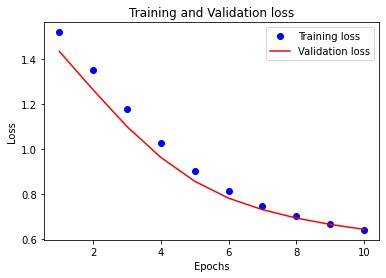

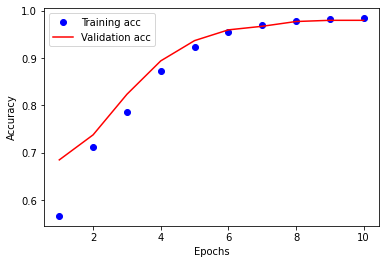

In [28]:
import matplotlib.pyplot as plt 
# display the loss curve 
plt.clf()

history_dict = train_history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs=range(1, len(history_dict["loss"]) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## validation accuracy 
plt.clf()
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs=range(1, (len(history_dict["accuracy"])+1))
plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "r", label="Validation acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [39]:
# finally testing our model on unseen data 

rawPreds = model.predict(test_data)
print(rawPreds.shape)

<class 'pandas.core.series.Series'>
I am looking for a train departing from london liverpool please .
(496, 5)


In [31]:
Preds = [] 
for j in range(rawPreds.shape[0]):
    pos=rawPreds[j].argmax()
    Preds.append(y_test.columns[pos])
    
print(len(Preds))

496


In [33]:
from sklearn.metrics import classification_report 
print(classification_report(Preds, test_labels))

                   precision    recall  f1-score   support

     Train-Inform       0.99      0.98      0.98       253
Train-OfferBooked       0.88      1.00      0.93        14
    Train-Request       0.95      0.96      0.95        97
      general-bye       0.98      0.89      0.94        57
    general-thank       0.90      0.96      0.93        75

         accuracy                           0.96       496
        macro avg       0.94      0.96      0.95       496
     weighted avg       0.96      0.96      0.96       496



In [36]:
print(test_data)

1609    OK , what are your departure and arrival stati...
2307    Where are you departing from , and what is you...
711     I can assist you with that .   Where are you t...
3325    The departure time from cambridge to liverpool...
3252    Hi , I need to get in from King 's Lynn to Cam...
                              ...                        
1468             I 'll be leaving on friday after 12:45 .
1762                                    Just one please .
3195    there is the information TR7423 \t cambridge \...
2739                           Where are you heading to ?
3228    Actually , I do n't need booking . Please just...
Name: text, Length: 496, dtype: object


In [37]:
print(rawPreds)
print(type(test_data))
print(test_data[0])

[[0.10150433 0.1281535  0.54439604 0.12198781 0.10395829]
 [0.10339168 0.12708841 0.5445942  0.12092398 0.10400168]
 [0.10586034 0.12306546 0.5365494  0.12432289 0.11020203]
 ...
 [0.5597215  0.12123333 0.09040532 0.10939442 0.11924537]
 [0.10487669 0.1232264  0.54055303 0.12830265 0.10304122]
 [0.12210152 0.12499055 0.5367919  0.11065549 0.10546053]]


In [44]:
test = model.predict(["can you tell me when the next departing train is heading for cork ?"])
print(test)

[[0.32365513 0.11614661 0.36011308 0.10493717 0.09514806]]


In [63]:

new_model = build_model(embed)
print(new_model.summary())
new_model.load_weights("checkpoint")


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   {'outputs': (None, 512)}  147354880 
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 2565      
Total params: 147,357,445
Trainable params: 147,357,445
Non-trainable params: 0
_________________________________________________________________
None


2021-07-29 15:33:05.556608: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ./checkpoint: Failed precondition: checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


OSError: Unable to open file (file read failed: time = Thu Jul 29 15:33:05 2021
, filename = 'checkpoint', file descriptor = 81, errno = 21, error message = 'Is a directory', buf = 0x7ffee4f5f6b8, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [64]:
model.save("acc_model.h5")

In [65]:
new_model = tf.keras.models.load_model("acc_model.h5")

ValueError: Unknown layer: KerasLayer